## Quantile Regression - Techniques 

The goal of this notebook is to understand the **implementation, usage and limitations of different techniques** that can be used for conducting a [quantile regression](https://en.wikipedia.org/wiki/Quantile_regression) analysis<sup>1</sup>.

For this purpose, it has been selected the **boston house price prediction** dataset. This dataset has been successfully applied with other techniques studied before: ['On-the-fly variance technique' and MDN (Mixture Density Networks)](https://github.com/beeva/TEC_LAB-bayesian_probabilistic/blob/master/bayesian_deep_learning/uncertainty_estimation/mixture_density_networks/experiments/01-mixture_density_networks/real_data_house_prices_mdn_techniqueI.ipynb)  

- [Boston Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)

#### Techniques 

As in the case of conventional regression analysis, in quantile regression we have different machine learning techniques that can be used to adjust a regression equation that (in this case) predicts the [conditional quantiles desired](https://en.wikipedia.org/wiki/Quantile)

The most simple method is the linear quantile regression. However, other methods can be used for finding the best quantile regression estimator<sup>2</sup>

- Linear quantile regression
- Random forest regression
- Gradient Boosting regression
- Deep quantile regression

<sup>1</sup> Here, we are interested in quantile regression *as a method to study the underlying uncertainty* of our model *predictions by means of prediction intervals*. However, this type of analysis might be useful for [other applications](https://github.com/beeva/TEC_LAB-bayesian_probabilistic/blob/85b938e3cc4e74454e8731f0070c5b9deb04e5b5/bayesian_deep_learning/uncertainty_estimation/quantile_regression/README.md#aplicaciones)

<sup>2</sup> Ensamble (random forest, gradient boosting) and deep learning methods (deep quantiles) are capable to model non-linear relationships and/or interaction between predictors as opposite of linear quantile regresssion

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from matplotlib.pyplot import figure

sns.set_palette(sns.color_palette('Blues'))
dot_color = sns.color_palette('coolwarm', 6)[1] # Set dots to a light gray

import statsmodels.api as sm
from scipy.stats import norm
from sklearn import ensemble

import tensorflow as tf
from tensorflow import keras  
tf.get_logger().setLevel('INFO')

mpl.rcParams['figure.figsize'] = 20, 10
np.random.seed(2019)

###  Boston house price dataset

*Why are we testing with the [boston dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)?*

The boston dataset is commonly used as a reference dataset in most of the BDL benchmarks [2][3]. Assessing the performance of BDL techniques may become very difficult since the **'uncertainty' evaluation may depend on the business domain**. There are many different valid interpretations (variance, prediction intervals, out-of-threshold prediction error etc.) . Here, **we focus in the business problem of predicting house prices in Boston and using the prediction intervals as uncertainty metric**

[1] Filos, A., Farquhar, S., Gomez, A. N., Rudner, T. G. J., Kenton, Z., Smith, L., … Gal, Y. (2019). A Systematic Comparison of Bayesian Deep Learning Robustness in Diabetic Retinopathy Tasks. (NeurIPS), 1–12. Retrieved from http://arxiv.org/abs/1912.10481

[2] Lakshminarayanan, B., Pritzel, A., & Blundell, C. (2017). Simple and scalable predictive uncertainty estimation using deep ensembles. Advances in Neural Information Processing Systems, 2017-Decem(Nips), 6403–6414.

#### Load the dataset

We select a single explanatory variable: <u>the average number of rooms (RM)</u>  in order to predict <u>Median value of owner-occupied homes</u> in $1000s (MEDV)

In [2]:
boston_housing = keras.datasets.boston_housing

(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
                'TAX', 'PTRATIO', 'B', 'LSTAT']

x_train = pd.DataFrame(train_data, columns=column_names).RM
x_test = pd.DataFrame(test_data, columns=column_names).RM

# An intercept is not included by default and should be added by the user. See statsmodels.tools.add_constant
X_train = sm.add_constant(x_train) 
X_test = sm.add_constant(x_test)

x_train_expanded = np.expand_dims(x_train, 1)
x_test_expanded = np.expand_dims(x_test, 1)
train_labels_expanded = np.expand_dims(train_labels, 1)

#### Exploratory data analysis of boston dataset

First, we will **visualize the data** and check if there some **heterocedasticity** (the variance of residuals/uncertainty is not the same for any value of X) so we have a rich enough dataset to evaluate uncertainty

**Homoscedasticity** is one of the **key fundamental assumptions** underlying linear regression based on OLS method. Here, we expect to study this fundamental limitation comparing the uncertainty obtained from both (OLS and quantiles)

In [3]:
ols = sm.OLS(train_labels, X_train).fit()
mean_pred = ols.predict(X_train)

*Train and test visualization*

Text(0, 0.5, 'Median value of owner-occupied homes in $1000s')

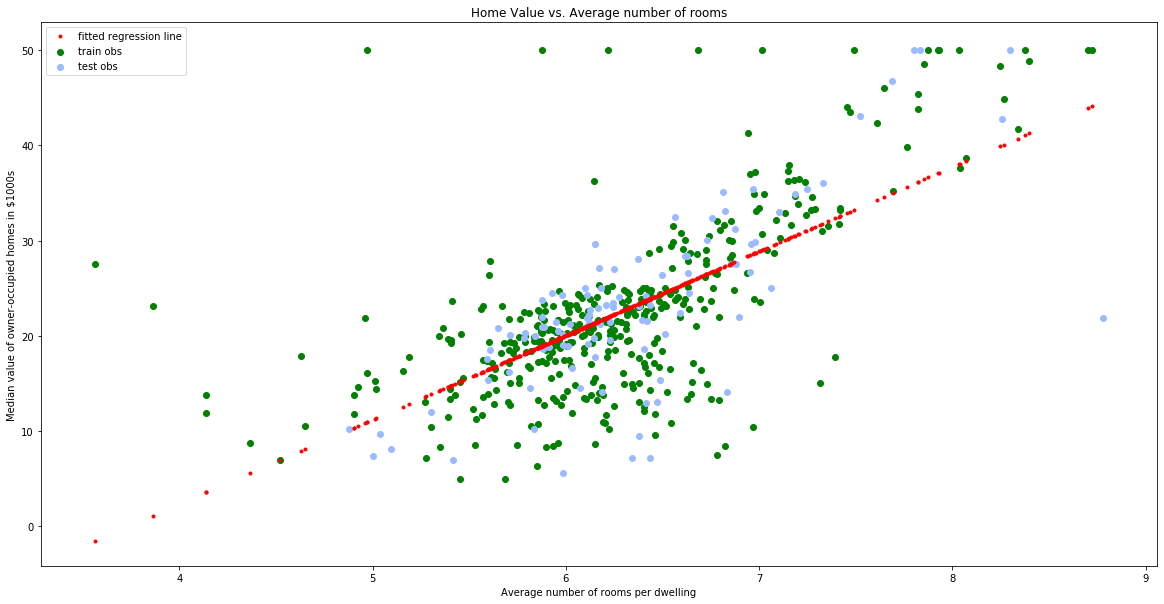

In [4]:
plt.plot(x_train, mean_pred, '.', color= 'red')
plt.scatter(x_train, train_labels, color= 'green')
plt.scatter(x_test, test_labels, color= dot_color)
plt.legend([r'fitted regression line', 'train obs', 'test obs'], loc='upper left', );
plt.title('Home Value vs. Average number of rooms')
plt.xlabel('Average number of rooms per dwelling')
plt.ylabel('Median value of owner-occupied homes in $1000s')

In this plot, it is represented the **relationship between the home value in $1000's and the number of rooms**. As we can see, there is a clear correlation (positive) between both variables that present some non-linearities

*Residuals visualization*

Here, it is computed the residuals as the difference between true value (train_label) and predictions. It is obtained with ols.resid method from statsmodels

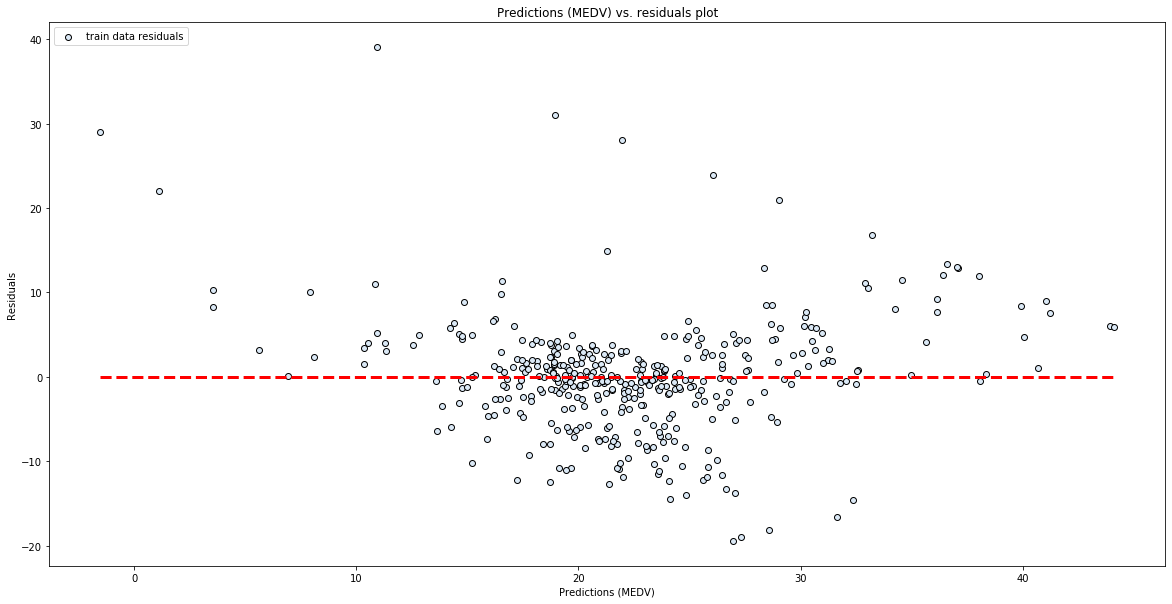

In [5]:
p = plt.scatter(x=ols.fittedvalues, y=ols.resid, edgecolor='k')
plt.hlines(y=0, xmin=min(ols.fittedvalues), xmax=max(ols.fittedvalues), color='red', linestyle='--', lw=3)
plt.legend([r'train data residuals'],  loc='upper left', );
plt.xlabel("Predictions (MEDV)")
plt.ylabel("Residuals")
plt.title("Predictions (MEDV) vs. residuals plot")
plt.show()

As we can see that **there is some [heterocedasticity](https://miro.medium.com/max/3326/1*Jan9oVOzNqQyhA4bSg_zwA.png)**: we see that the dispersion of the residuals for the predicted value (house price) at x=20 is lower than x=28. There is also a decreasing trend beyond x=30

## Techniques

The methods under study are the following:

   * **OLS**: (Baseline method). The estimation of uncertainty using Ordinary Least Square. This technique will give us the commonly used Confidence Intervals to model uncertainty using a frequetist approach
   
Quantile regression techniques:
   * **Quantile Regression**: The most common and simpliest technique of quantile regression problems. We can consider this method as another baseline using a bayesian approach<sup>3</sup> 
   * **Quantile Random Forest**: Implementation with ensamble methods capable of learning non-linear patterns
   * **Quantile Gradient Boosting**: Part of ensamble methods. This technique is selected for being a common baseline in ML problems
   * **Deep Quantile Regression**: The aplication of quantile regression with Deep Learning

<sup>3</sup> *Here, we are using the [soft interpretation of the bayesian framework](https://en.wikipedia.org/wiki/Bayesian_probability) so we consider as 'bayesian' a method that allow us to update our state of belief with the incorporation of new obs. If we translate this concept to ML models, we are capable of getting an aprox. distribution of $P(Y|X=xi)$ which is dependent on a particular obs xi*

### Benchmark execution

First, we will setup some common paremeters to execute a benchmark that shows the performance of different implementations of the technique quantile regression 

#### Benchmark - Parameters selection

Here, we have selected 5 quantiles to estimate uncertainty [0.1, 0.3, 0.5, 0.7, 0.9] for evaluation purposes. However, in real applications other quantiles can be selected according to the business needs. 

Using these quantiles, we are estimating uncertainty (the range of values that we our prediction may take) with a 80% confidence as maximum. The wider is this interval, the more uncertain the prediction will be.

In [6]:
METHODS = ['OLS', 'Quantile Regresion', 'Quantile Random forests', 'Quantile Gradient boosting', 'Deep Quantile Regression']
QUANTILES = [0.1, 0.3, 0.5, 0.7, 0.9]

As I have specified 5 quantiles, we will need to adjust 5 different models for each selected method

In [7]:
preds = np.array([(method, q, x) 
                  for method in METHODS 
                  for q in QUANTILES
                  for x in x_test])

preds = pd.DataFrame(preds)
preds.columns = ['method', 'q', 'x']
preds = preds.apply(lambda x: pd.to_numeric(x, errors='ignore'))

In [8]:
preds['test_label'] = np.resize(test_labels, preds.shape[0])

#### OLS Linear regression

* *Reference post* with explanations of these two concepts: [Confidence intervals vs. Predictions Intervals](https://towardsdatascience.com/how-confidence-and-prediction-intervals-work-4592019576d8)

This is the frequentist approach of estimating the uncertainty. There is a reference notebook that shows the implementation of [confidence intervals with linear regression](https://github.com/beeva/TEC_LAB-bayesian_probabilistic/blob/master/bayesian_deep_learning/uncertainty_estimation/non_bayesian_techniques/experiments/boostrapping_confidence_intervals.ipynb).

This approach considers model value parameters (and predictions) not conditioned to any specific observation P(Y|X=x). Thus, these confidence intervals tells you the range of values that the coefficients of linear regression equation may take considering only the training dataset (as a whole)

*Intuitive explanation of the implemenation*

In order to implement this approach, we assume the coefficients and residuals to follow a normal distribution (based on the [central limit theorem](https://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_probability/BS704_Probability12.html#:~:text=The%20central%20limit%20theorem%20states,will%20be%20approximately%20normally%20distributed)). Considering this fact, we compute the standard deviation of the model residuals (SE) and the corresponding desired quantiles values of a normal distribution with norm.ppf(q)

In [9]:
def ols_quantile(m, X_test, q):
    # m: OLS model.
    # X: X matrix.
    # q: Quantile.
    mean_pred = m.predict(X_test)
    se = np.sqrt(m.scale) #  estimated scale of the residuals
    return mean_pred + norm.ppf(q) * se

In [10]:
ols = sm.OLS(train_labels, X_train).fit()
preds.loc[preds.method == 'OLS', 'pred'] = np.concatenate(
    [ols_quantile(ols, X_test, q) for q in QUANTILES]) 

#### Quantile Regression

[Quantile Linear Regression](https://www.statsmodels.org/devel/generated/statsmodels.regression.quantile_regression.QuantReg.html)

This method estimates a quantile regression model using *iterative reweighted least squares*

* *Reference video* with implementation details of the [IRLS (iterative reweighted least squares) method](https://www.bing.com/videos/search?q=weighted+least+squares+youtube&&view=detail&mid=046ACCEE252204451364046ACCEE252204451364&&FORM=VDRVSR)

* *Reference lecture* with [IRSL algorithm](http://www2.maths.lth.se/matematiklth/personal/fredrik/Session3.pdf).

*Intuitive explanation of weighted least squares*

The OLS method described above treats all standard error deviations from all data points in the same way. Here, we take into account heterocedasticity and we assign different weights to errors coming from data points in high and low variability regions. 

Here, we assign a lower weight to points with high variability (higher deviation from the mean) and higher weights to points with lower variability. In this way, we have a more robust estimator (less affected by outliers)

*Quantile linear regression*

Here, it is used the same concept as IRSL, however weights are assigned depending on the selected quantile.

In [11]:
quantreg = sm.QuantReg(train_labels, X_train) 
preds.loc[preds.method == 'Quantile Regresion', 'pred'] = np.concatenate(
    [quantreg.fit(q=q).predict(X_test) for q in QUANTILES]) 

#### Quantile Random forest

* *Reference post* with the implementation explanation [Quantile Random Forest](https://www.cienciadedatos.net/documentos/53_regresion_cuantilica_quantile_regresion_forest.html)

The standard random forests gets the conditional mean by taking the mean of the 100 predicted values. Here, we extend this to get the entire distribution thus the confidence intervals. The idea behind is similar to the implementation of [confidence intervals with linear regression](https://github.com/beeva/TEC_LAB-bayesian_probabilistic/blob/master/bayesian_deep_learning/uncertainty_estimation/non_bayesian_techniques/experiments/boostrapping_confidence_intervals.ipynb).

In [12]:
N_ESTIMATORS = 1000
rf = ensemble.RandomForestRegressor(n_estimators=N_ESTIMATORS, 
                                    min_samples_leaf=1, random_state=3, 
                                    verbose=True, 
                                    n_jobs=-1)  # Use maximum number of cores.
rf.fit(X_train, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.6s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=-1, oob_score=False,
                      random_state=3, verbose=True, warm_start=False)

In [13]:
def rf_quantile(m, X, q):
    rf_preds = []
    for estimator in m.estimators_:
        rf_preds.append(estimator.predict(X))
    rf_preds = np.array(rf_preds).transpose()  # One row per record.
    return np.percentile(rf_preds, q * 100, axis=1) # get the corresponding quantile of rf_preds distribution

In [14]:
preds.loc[preds.method == 'Quantile Random forests', 'pred'] = np.concatenate(
    [rf_quantile(rf, X_test, q) for q in QUANTILES]) 

#### Gradient Boosted trees

* *Reference post* with the implementation explanation [Gradient Boosting Quantile Regression](https://www.cienciadedatos.net/documentos/56_regresion_cuantilica_gradient_boosting.html)

* *Reference Notebook* with the explanation of the loss function used in this technique: [Deep Quantile Regression - Loss function](https://github.com/beeva/TEC_LAB-bayesian_probabilistic/blob/master/bayesian_deep_learning/uncertainty_estimation/quantile_regression/experiments/01-quantile_regression/quantile_regression_loss_functions.ipynb)

The implementation of this method follows a similar idea as quantile random forest. However, here we compute the final prediction taking into account the results of the base learners in a sequential manner (boosting method) with the quantile loss in the optimization process

In [15]:
N_ESTIMATORS = 1000
def gb_quantile(X_train, train_labels, X, q):
    gbf = ensemble.GradientBoostingRegressor(loss='quantile', alpha=q,
                                             n_estimators=N_ESTIMATORS,
                                             max_depth=3,
                                             learning_rate=0.1, min_samples_leaf=9,
                                             min_samples_split=9)
    gbf.fit(X_train, train_labels)
    return gbf.predict(X)

In [16]:
preds.loc[preds.method == 'Quantile Gradient boosting', 'pred'] = np.concatenate(
    [gb_quantile(X_train, train_labels, X_test, q) for q in QUANTILES]) 

#### Deep Quantile Regression

* Reference post with the technique explanation: [Quantile loss aplication Deep Quantile Regression](https://towardsdatascience.com/deep-quantile-regression-c85481548b5a)
* Reference Notebook with the explanation of the loss function used in this technique: [Deep Quantile Regression - Loss function](https://github.com/beeva/TEC_LAB-bayesian_probabilistic/blob/master/bayesian_deep_learning/uncertainty_estimation/quantile_regression/experiments/01-quantile_regression/quantile_regression_loss_functions.ipynb)

Deep Quantile Regression estimates prediction intervals using the [Pinball loss](https://www.lokad.com/es/definicion-funcion-de-perdida-pinball) function for optimization 

Here, we implement the naive method of deep quantile regression. This method fits N Deep Quantile models, one for each quantile. 

In [17]:
EPOCHS = 200
BATCH_SIZE = 32
UNITS = 512

In [19]:
def tilted_loss(q, y, f):
    e = (y - f)
    #e = (f - y)
    return keras.backend.mean(keras.backend.maximum(q * e, (q - 1) * e), axis=-1)

In [20]:
optimizer = tf.optimizers.Adam(0.001)
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [21]:
def deepquantile_pred(x_train, train_labels, x_test, q):
    # Set input_dim for the number of features.
    if len(x_train.shape) == 1:
        input_dim = 1
    else:
        input_dim = x_train.shape[1]
        
    model = keras.Sequential([
      keras.layers.Dense(UNITS, activation=tf.nn.relu,
                         input_dim=input_dim),
      keras.layers.Dense(UNITS, activation=tf.nn.relu),
      keras.layers.Dense(1)
    ])
    
    model.compile(loss=lambda y, f: tilted_loss(q, y, f), optimizer=optimizer)
    model.fit(x_train, train_labels, epochs=EPOCHS, batch_size=BATCH_SIZE,
              verbose=0, validation_split=0.2, callbacks=[early_stop])
    
    # Predict the quantile
    return model.predict(x_test)

In [22]:
preds.loc[preds.method == 'Deep Quantile Regression', 'pred'] = np.concatenate(
    [deepquantile_pred(x_train_expanded, train_labels, x_test_expanded, q) 
     for q in QUANTILES]) 

## Result Analysis

The validation of results will be done in two steps:
   * **Global validation**: Predictions results are evaluated globally for the whole testing dataset based on the average pinball loss of each method per quantile
   * **Point-of-estimate validation**: Predictions results are visualized and analysed per quantile

### Global validation

In this section, it is analysed and compared the prediction results obtained with each method. Prediction results are evaluated per each quantile using the **Pinball Loss** described in the Notebook [Deep Quantile Regression - Loss function](https://github.com/beeva/TEC_LAB-bayesian_probabilistic/blob/master/bayesian_deep_learning/uncertainty_estimation/quantile_regression/experiments/01-quantile_regression/quantile_regression_loss_functions.ipynb)

This evaluation method has been proposed as a reference metric in Kaggle competitions such as [COVID-19 Global forecasting](https://www.kaggle.com/c/covid19-global-forecasting-week-5/overview) and [M5 Forecasting Uncertainty](https://www.kaggle.com/c/m5-forecasting-uncertainty)

#### Evaluation function

Here, it is computed the pinball loss per each quantile using the generated result dataframe named 'preds'. The Pinball loss function is the same as the one defined before for Keras in Deep Quantile Regression but adapted to work with df series values 

In [23]:
def pinball_loss(actuals, preds, u):
    """Returns the pinball loss for each series"""
    return np.where(actuals >= preds, (actuals - preds) * u, (preds - actuals) * (1 - u))

In [24]:
preds.head()

,method,q,x,test_label,pred
0,OLS,0.1,6.434,7.2,15.222074
1,OLS,0.1,5.913,18.8,10.614795
2,OLS,0.1,5.985,19.0,11.251502
3,OLS,0.1,6.250,27.0,13.594935
4,OLS,0.1,6.121,22.2,12.454169


We generate the final result dataframe with the computed pinball_loss

In [25]:
preds['pinball_loss'] = pinball_loss(preds.test_label, preds.pred, preds.q)
preds.head()

,method,q,x,test_label,pred,pinball_loss
0,OLS,0.1,6.434,7.2,15.222074,7.219866
1,OLS,0.1,5.913,18.8,10.614795,0.818520
2,OLS,0.1,5.985,19.0,11.251502,0.774850
3,OLS,0.1,6.250,27.0,13.594935,1.340507
4,OLS,0.1,6.121,22.2,12.454169,0.974583


#### Plot results

Finally, results are visualized in the following plot to compare the performance of each technique 

[Text(0, 0.5, 'Mean Pinball Loss'), Text(0.5, 0, 'Quantile')]

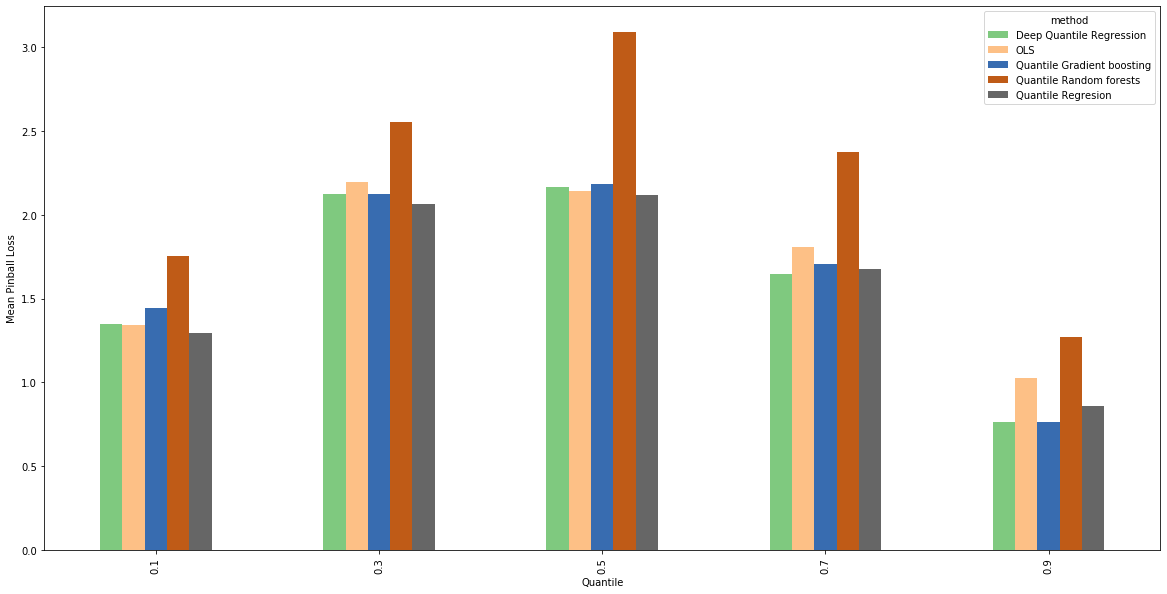

In [26]:
ax = preds.groupby(['method','q'])['pinball_loss'].mean().unstack().T.plot(kind='bar', colormap='Accent')
ax.set(xlabel='Quantile', ylabel='Mean Pinball Loss')

**Insights**:
   * Quantile Random Forest performs relatively bad comparing to the rest of techniques
   * The best methods are Quantile Gradient Boosting and Deep Quantile Regression. Both methods use the quantile loss for the optimization of the parameters of the model in a sequential manner. This metric seems to result a good choice for evaluating predictions in both phases: training and validation.
   * OLS performs relatively well in terms of global validation loss per quantile

In [27]:
preds.to_csv('benchmark_quantile_regression_techniques.csv', index=False)

### Point-of-estimate validation

Here, we will visualized quantile prediction results per each method 

#### Visualization of prediction results

In [42]:
quantiles_legend = [str(int(q * 100)) + 'th percentile' for q in QUANTILES]
quantiles_legend.extend(['test obs','train obs'])

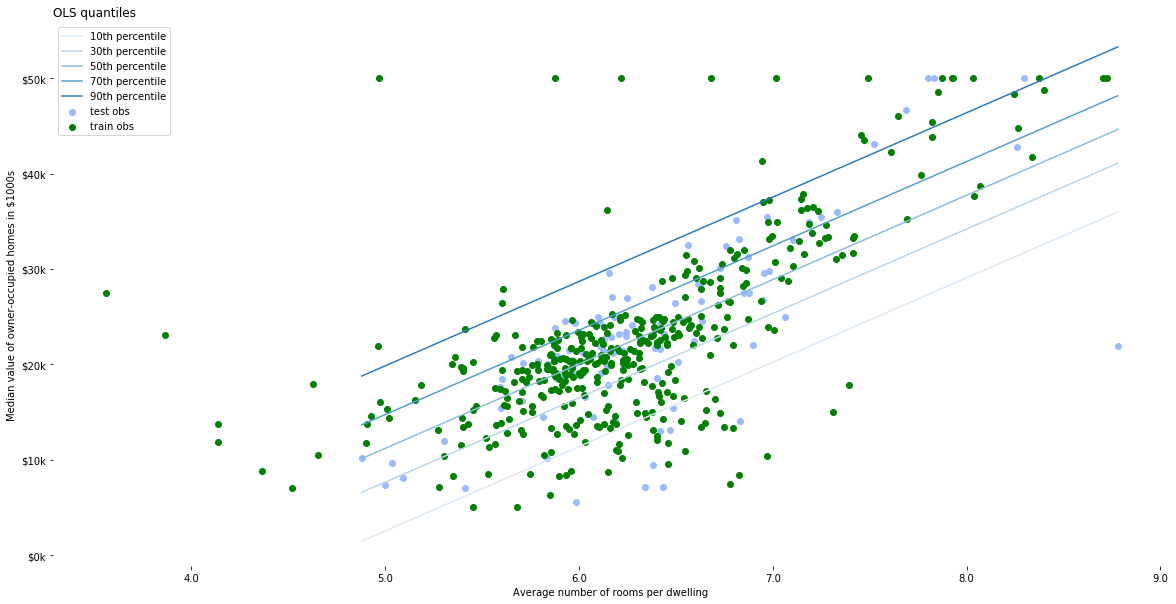

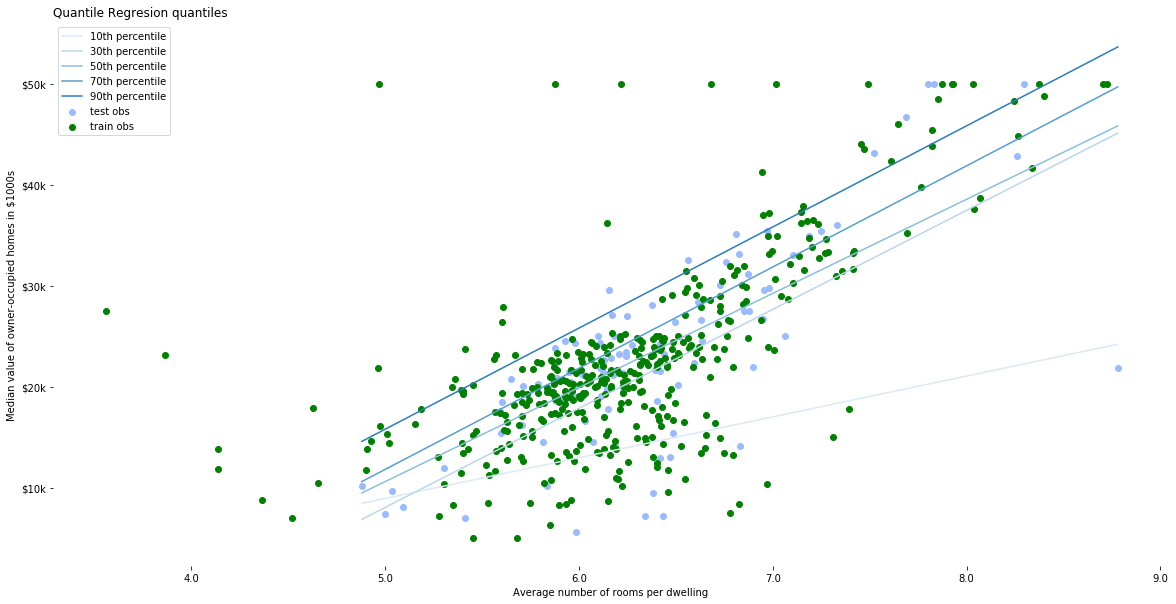

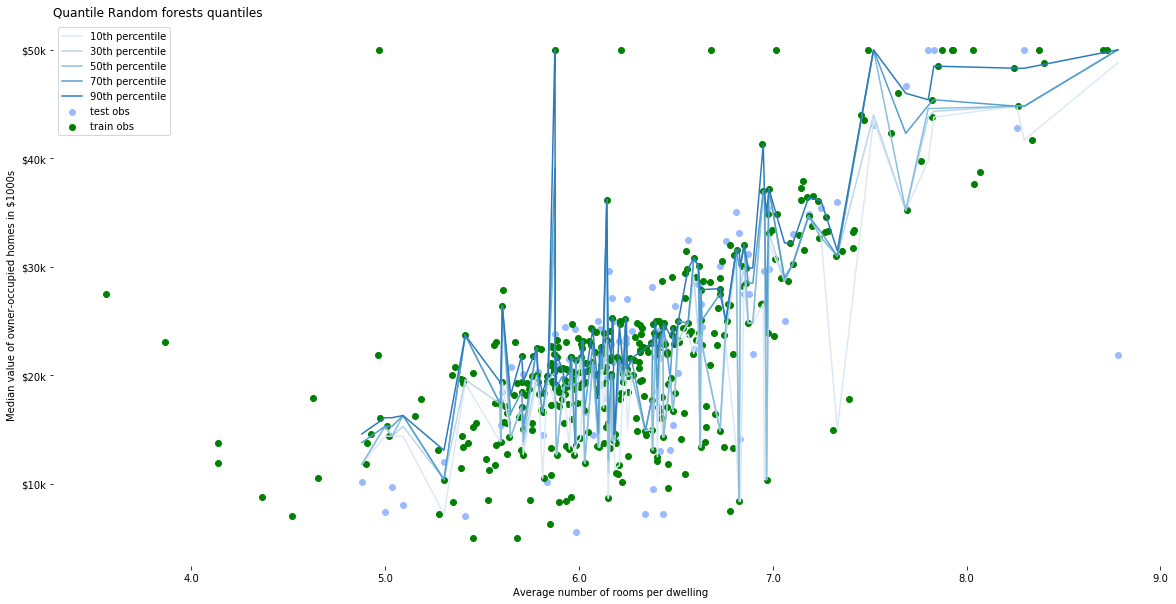

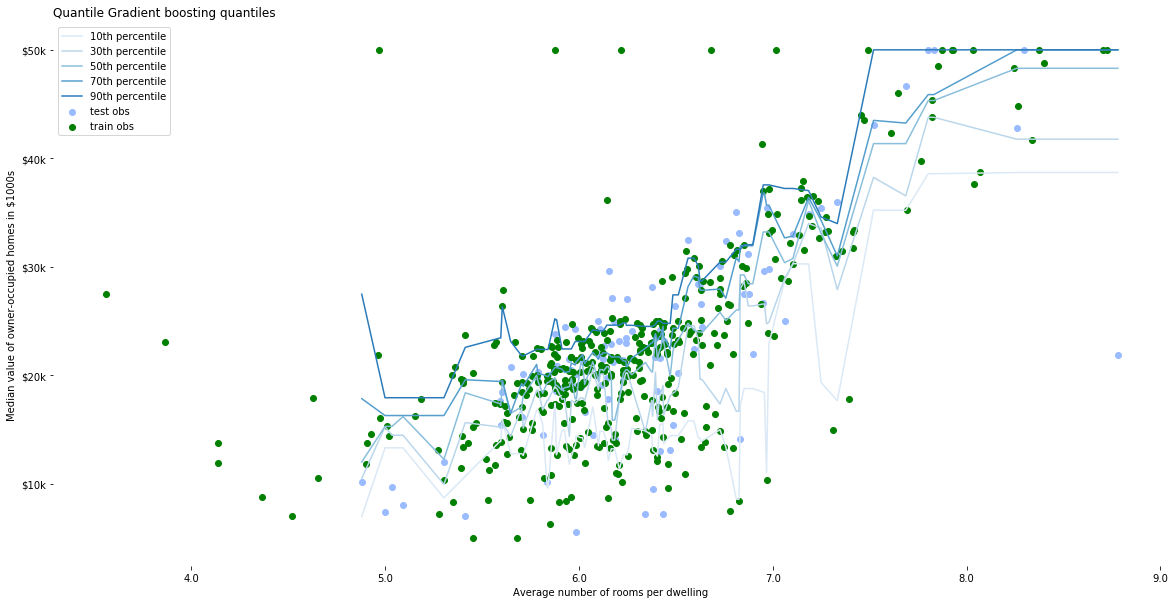

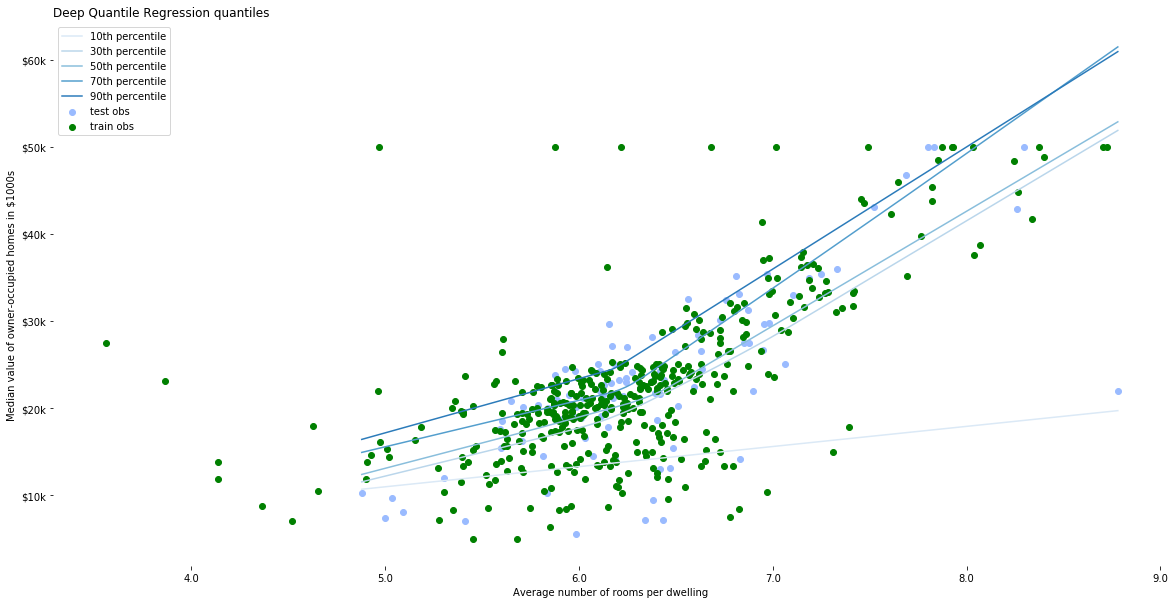

In [43]:
for i, method in enumerate(METHODS):
    ax = plt.scatter(x_test, test_labels, color=dot_color)
    plt.scatter(x_train, train_labels, color= 'green')
    plt.plot(preds[preds.method == method].pivot_table(
        index='x', columns='q', values='pred'))

    
    ax.axes.xaxis.set_major_formatter(FuncFormatter(
        lambda x, _: '{:}'.format(x)))
    ax.axes.yaxis.set_major_formatter(FuncFormatter(
        lambda y, _: '${:.0f}k'.format(y)))
    plt.xlabel('Average number of rooms per dwelling')
    plt.ylabel('Median value of owner-occupied homes in $1000s')
    plt.title(method + ' quantiles', loc='left')
    sns.despine(left=True, bottom=True)
    plt.legend(quantiles_legend)
    plt.show()

In this plot we can observe the quantiles estimation with the different proposed techniques. These techniques present different behaviors, the more relevant insights found from the visualization of the prediction results of each of them are: 


**Insights**:

* **OLS** uses the frequentist approach to estimate uncertainty by means of confidence intervals. This method is not capable of modelling an heterocedastic uncertainty. The resulting regression equation is a straight line with constant variance.

* **Quantile regression** unlike OLS is capable of modelling some global variance present (heterocedasticity) in the dataset. However, it is still a linear approximator not capable of modelling a non-constance variance as OLS.

* **Ensamble methods** such as Random Forest and Gradient Boosting are more affected by outliers. These methods give a very good performance in the testing set but they are more sucespectible to learn from noise (High variance overfitting). It migh not be a good method in presence of high heterocedasticity or variance.

* **Deep quantile regression** methods present a similar behavior to quantile regression but as we can see in the last plot it is possible to estimate non-linear patterns. However, this flexibility produce the third and fourth quantile crossing in X~0.75. This might causes a performance degradation and interpretability problems. 

### Conclusions

See **insights** from Result Analysis section for detailed conclusions

Goals achieved in this notebook:

* Validation of the technique **deep quantile regression as a baseline** for estimating uncertainty (prediction intervals) in presence of heterocedasticity. 
*This technique presents a good flexibility for modelling heterocedasiticity uncertainty and it is not prone to overfitting (with high variance datasets).*
* Validation of the **quantile/pinball loss for evaluating heterocedastic uncertainty**. Additionally, this metric seems to be a reference in most prediction interval benchmarks.   



* Implementation of the most common techniques used for quantile estimation. The implementation of each technique and libraries used could be taken as a reference.
* Understand the behavior and limitations of each of them using a toy dataset included in scikit-learn

### Future Work

* For further investigation on the limitations of each of them it might be necessary to apply them to a **real dataset**. The dataset used here is simplified and normalized to ease the usage for the data science community

* Continue with the validation of Deep Quantile Regression techniques and the **quantile crossing problem**. We choose to continue with this technique because it is considered a baseline for **estimating forecasting uncertainty**
